In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import STOPWORDS, WordCloud

In [2]:
df = pd.read_csv("../combined_df.csv")
column_names = df.columns
print(column_names)

Index(['text', 'timestamp', 'username', 'link', 'link_id', 'parent_id', 'id',
       'subreddit_id', 'moderation', 'year', 'word_count', 'Sensitive Group',
       'Classification', 'clean_text', 'custom_topic', 'Topic_Words',
       'Final Topic', 'Final Topic Name', 'Topic Num'],
      dtype='object')


In [3]:
unique_values = df["Classification"].unique()
print("Unique values in the 'Classification' column:", unique_values)

Unique values in the 'Classification' column: ['Toxic 2' 'Toxic 1' 'Hate 1' 'Toxic 3' 'Hate 2' 'Hate 3']


In [4]:
# Filter rows with non-null 'Final Topic Name'
df_filtered = df[df["Final Topic Name"].notnull()]

# Group by 'year' and 'Final Topic Name' and count the total number of classification rows
df_summary = (
    df_filtered.groupby(["year", "Final Topic Name"])
    .size()
    .reset_index(name="Classification Count")
)

# Displaying the summary
print(df_summary)

    year Final Topic Name  Classification Count
0   2020       Body Image                    83
1   2020         COVID-19                   269
2   2020           Crimes                   395
3   2020        Education                    86
4   2020           Gender                   336
5   2020     Generational                   202
6   2020       Government                   300
7   2020          Housing                    97
8   2020           LGBTQ+                   155
9   2020             Race                  2093
10  2020         Religion                   335
11  2020   Transportation                   141
12  2020             Work                   156
13  2021       Body Image                    88
14  2021         COVID-19                   725
15  2021           Crimes                   566
16  2021        Education                   134
17  2021           Gender                   427
18  2021     Generational                   216
19  2021       Government               

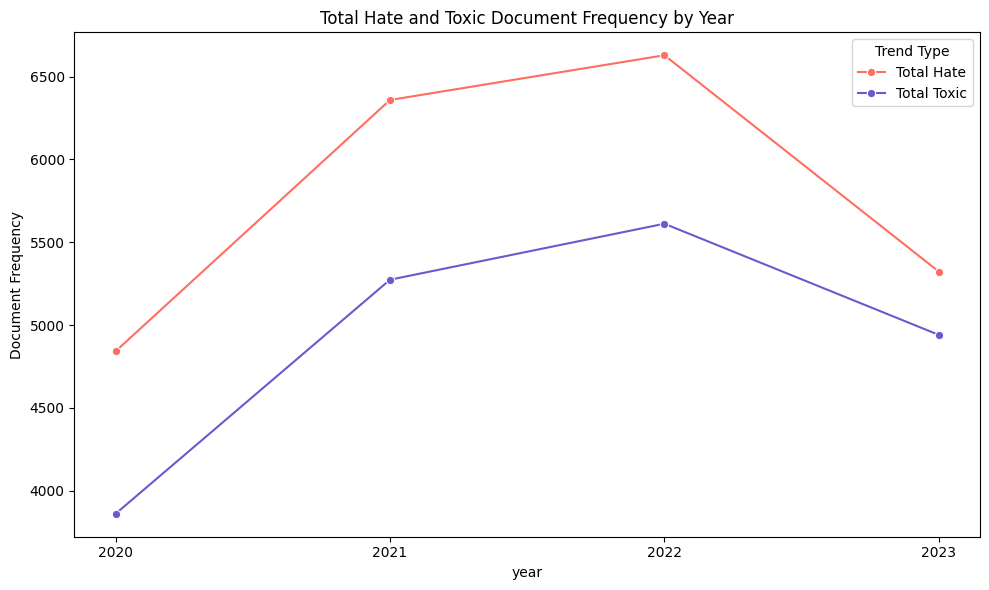

In [5]:
hate_trend_total = (
    df[df["Classification"].str.startswith("Hate")]
    .groupby("year")
    .size()
    .reset_index(name="Total Hate")
)
toxic_trend_total = (
    df[df["Classification"].str.startswith("Toxic")]
    .groupby("year")
    .size()
    .reset_index(name="Total Toxic")
)

# Merge the hate and toxic trends into a single DataFrame for easy plotting
trend_total = pd.merge(
    hate_trend_total, toxic_trend_total, on="year", how="outer"
).fillna(0)

# Plotting the total frequencies of hate and toxic documents by year
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=trend_total,
    x="year",
    y="Total Hate",
    marker="o",
    label="Total Hate",
    color="#FF6F61",
)
sns.lineplot(
    data=trend_total,
    x="year",
    y="Total Toxic",
    marker="o",
    label="Total Toxic",
    color="#6A5ACD",
)

# Customize the plot
plt.title("Total Hate and Toxic Document Frequency by Year")
plt.xlabel("year")
plt.ylabel("Document Frequency")
plt.xticks(trend_total["year"])  # Display each year on x-axis
plt.legend(title="Trend Type")
plt.tight_layout()

# Show plot
plt.show()

In [6]:
def plot_topic_proportions(df_filtered, topic_column="Final Topic Name"):
    """
    Plots the proportions of each topic in the DataFrame.

    Parameters:
    - df_filtered: The DataFrame containing the data.
    - topic_column: The column name for the topics. Default is "Final Topic Name".
    """
    # Step 1: Count the occurrences of each topic
    topic_counts = df_filtered.groupby(topic_column).size().reset_index(name="Count")
    
    # Step 2: Calculate the total count and the percentage for each topic
    total_count = topic_counts["Count"].sum()
    topic_counts["Percentage"] = (topic_counts["Count"] / total_count) * 100
    
    # Step 3: Plotting the proportions
    plt.figure(figsize=(10, 6))
    sns.barplot(data=topic_counts, x=topic_column, y="Percentage", palette="viridis")

    # Customize the plot
    plt.title("Proportion of Each Topic Across All Years")
    plt.xlabel(topic_column)
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

C:\Users\Yi Jing\AppData\Local\Temp\ipykernel_22500\4029911807.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topic_counts, x=topic_column, y="Percentage", palette="viridis")


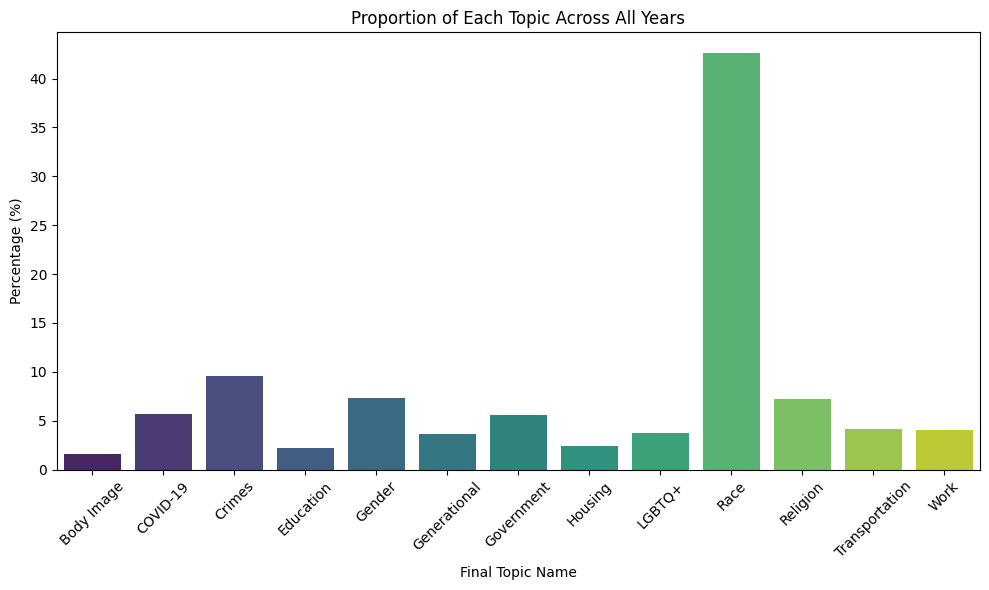

In [7]:
plot_topic_proportions(df_filtered)


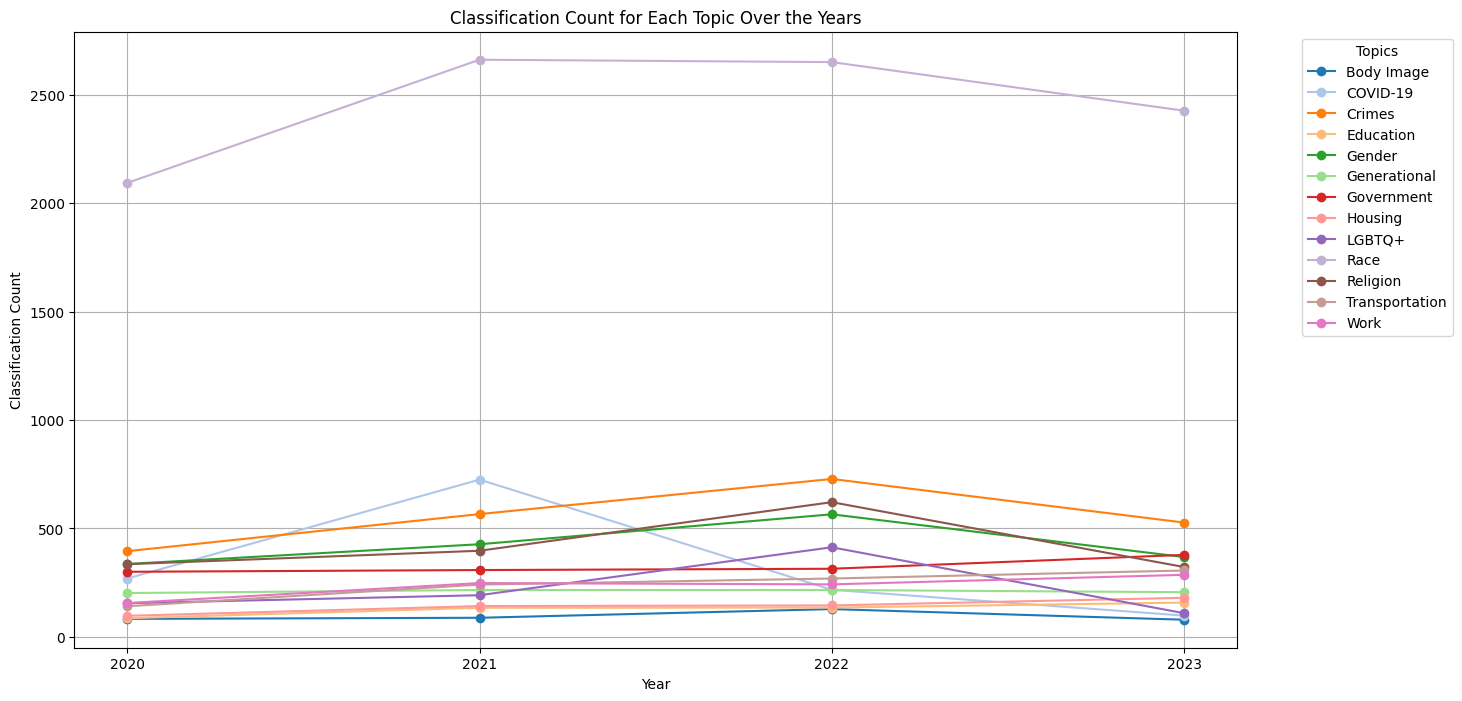

In [8]:
# Create a color map for consistent colors
df_summary_all = df_summary.copy()
unique_topics = df_summary_all["Final Topic Name"].unique()
color_map = {topic: plt.cm.tab20(i % 20) for i, topic in enumerate(unique_topics)}

# Ensure 'year' is numeric
df_summary_all["year"] = pd.to_numeric(df_summary_all["year"])

# Sort the data by 'year' and 'Final Topic Name'
df_summary_all = df_summary_all.sort_values(by=["year", "Final Topic Name"])

# Plotting classification count for all topics over the years
plt.figure(figsize=(15, 8))
for topic in df_summary_all["Final Topic Name"].unique():
    topic_data = df_summary_all[df_summary_all["Final Topic Name"] == topic]
    plt.plot(
        topic_data["year"],
        topic_data["Classification Count"],
        marker="o",
        label=topic,
        color=color_map[topic],
    )

plt.title("Classification Count for Each Topic Over the Years")
plt.xlabel("Year")
plt.ylabel("Classification Count")
plt.xticks(sorted(df_summary_all["year"].unique()))
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(visible=True)

# Show plot
plt.show()

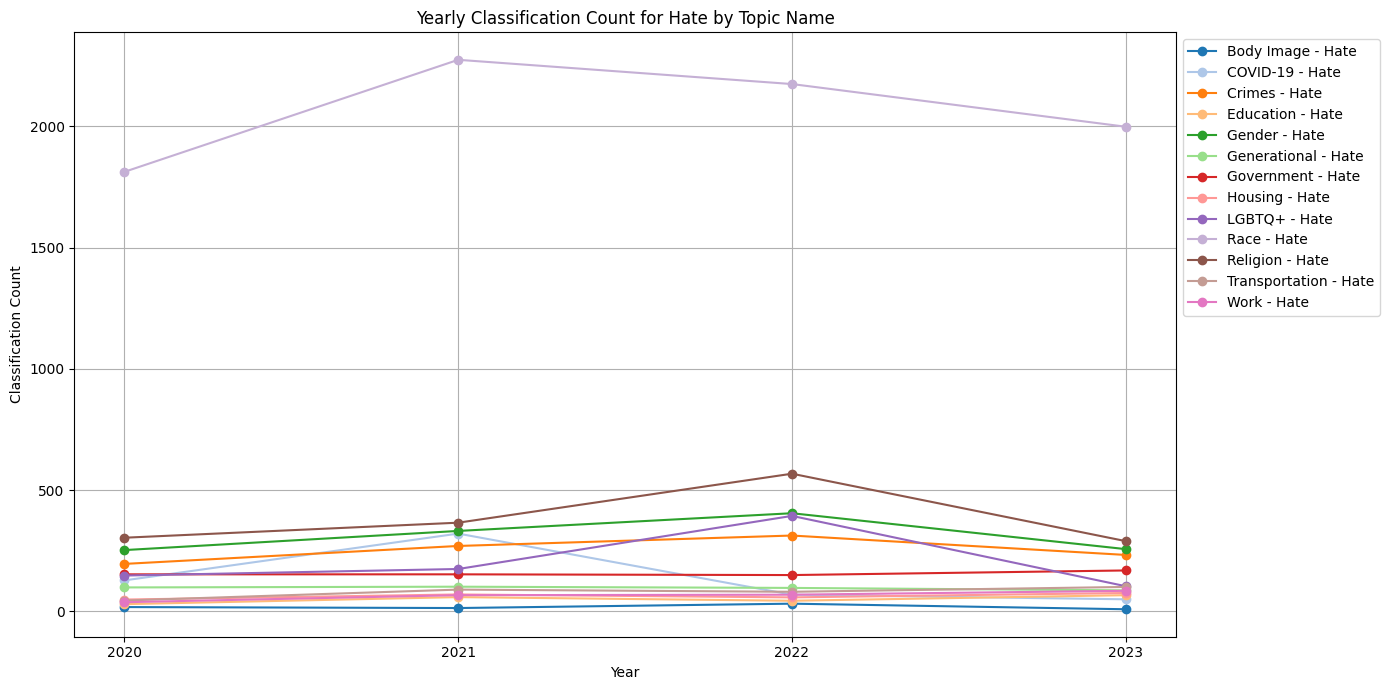

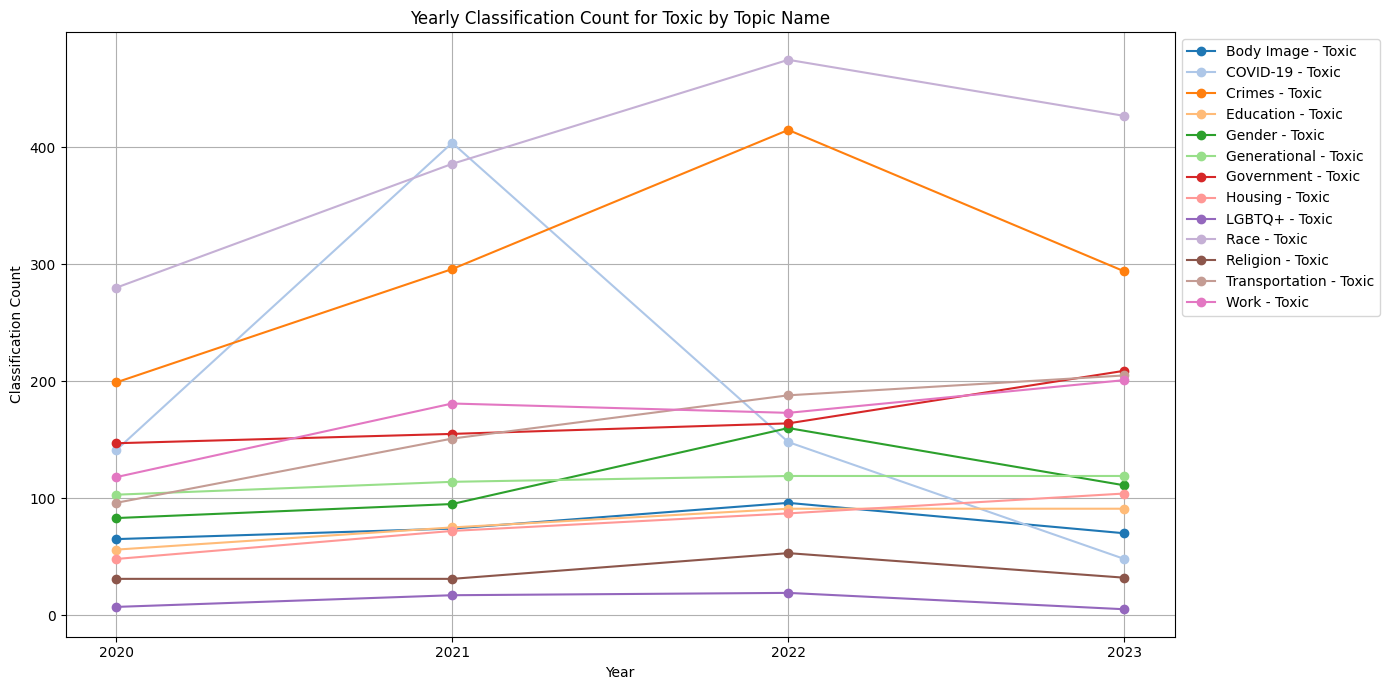

In [9]:
# Assuming the DataFrame 'df' is already defined and the mapping has been applied
classification_map = {
    "Toxic 1": "Toxic",
    "Toxic 2": "Toxic",
    "Toxic 3": "Toxic",
    "Hate 1": "Hate",
    "Hate 2": "Hate",
    "Hate 3": "Hate",
}

# Apply the mapping to create a new 'General Classification' column
df["General Classification"] = df["Classification"].map(classification_map)

# Filter out rows with non-null 'Final Topic Name'
df_filtered = df[df["Final Topic Name"].notnull()]

# Group by 'year', 'Final Topic Name', and 'General Classification' and count the number of occurrences
df_hate_toxic = (
    df_filtered.groupby(["year", "Final Topic Name", "General Classification"])
    .size()
    .reset_index(name="Classification Count")
)
unique_topics = df_hate_toxic["Final Topic Name"].unique()
color_map = {topic: plt.cm.tab20(i % 20) for i, topic in enumerate(unique_topics)}
# Get the range of years for setting x-ticks
years = sorted(df_hate_toxic["year"].unique())

# Plotting the classification count for 'Hate'
plt.figure(figsize=(14, 7))
subset_hate = df_hate_toxic[df_hate_toxic["General Classification"] == "Hate"]
for topic_name in subset_hate["Final Topic Name"].unique():
    topic_subset = subset_hate[subset_hate["Final Topic Name"] == topic_name]
    if not topic_subset.empty:
        plt.plot(
            topic_subset["year"],
            topic_subset["Classification Count"],
            marker="o",
            label=f"{topic_name} - Hate",
            color=color_map[topic_name],
        )

plt.title("Yearly Classification Count for Hate by Topic Name")
plt.xlabel("Year")
plt.ylabel("Classification Count")
plt.xticks(years)  # Set x-ticks to be whole years only
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting the classification count for 'Toxic'
plt.figure(figsize=(14, 7))
subset_toxic = df_hate_toxic[df_hate_toxic["General Classification"] == "Toxic"]
for topic_name in subset_toxic["Final Topic Name"].unique():
    topic_subset = subset_toxic[subset_toxic["Final Topic Name"] == topic_name]
    if not topic_subset.empty:
        plt.plot(
            topic_subset["year"],
            topic_subset["Classification Count"],
            marker="o",
            label=f"{topic_name} - Toxic",
            color=color_map[topic_name],
        )

plt.title("Yearly Classification Count for Toxic by Topic Name")
plt.xlabel("Year")
plt.ylabel("Classification Count")
plt.xticks(years)  # Set x-ticks to be whole years only
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

From the frequency graphs, can see that in terms of frequency, racism is consistently high throughout the years

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming 'df' is your DataFrame
# Pivot table for the heatmap
df_filtered = df[df["Final Topic Name"].notnull()]

# Group by 'year' and 'Final Topic Name' and count the total number of classification rows
df_summary_2 = (
    df_filtered.groupby(["year", "Final Topic Name", "Classification"])
    .size()
    .reset_index(name="Classification_Count")
)

# Displaying the summary
print(df_summary_2)

     year Final Topic Name Classification  Classification_Count
0    2020       Body Image         Hate 1                    18
1    2020       Body Image        Toxic 1                    43
2    2020       Body Image        Toxic 2                    22
3    2020         COVID-19         Hate 1                   121
4    2020         COVID-19         Hate 2                     6
..    ...              ...            ...                   ...
263  2023             Work         Hate 2                     1
264  2023             Work         Hate 3                     1
265  2023             Work        Toxic 1                   159
266  2023             Work        Toxic 2                    39
267  2023             Work        Toxic 3                     3

[268 rows x 4 columns]


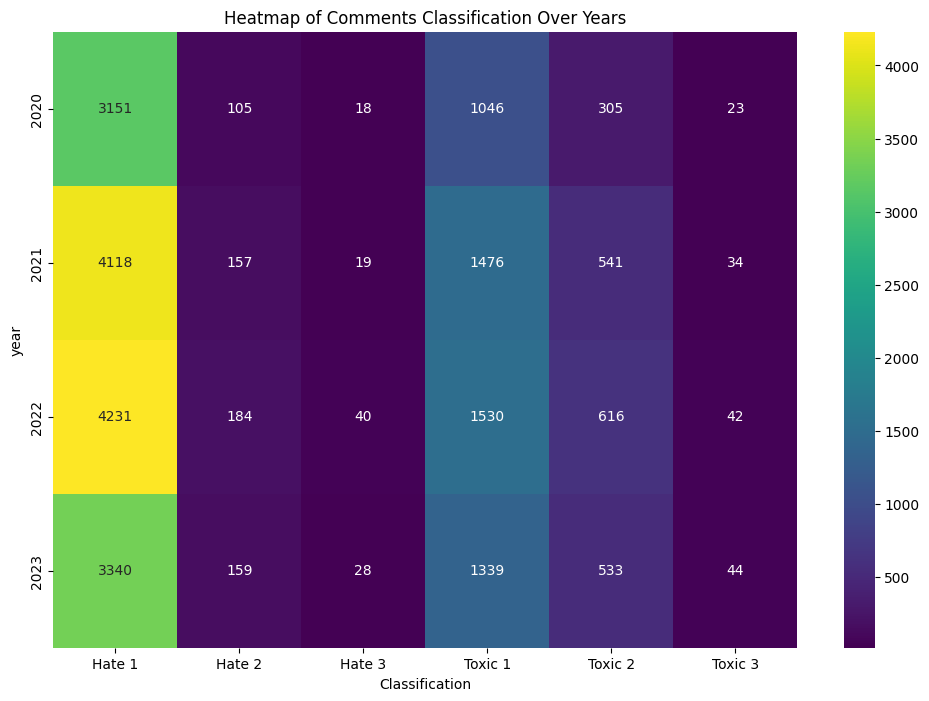

In [11]:
# Assuming 'df' is your DataFrame
# Pivot table for the heatmap
heatmap_data = df_summary_2.pivot_table(
    index="year", columns="Classification", values="Classification_Count", aggfunc="sum"
)

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".0f")
plt.title("Heatmap of Comments Classification Over Years")
plt.show()

In [12]:
df_hate_toxic.head()

,year,Final Topic Name,General Classification,Classification Count
0,2020,Body Image,Hate,18
1,2020,Body Image,Toxic,65
2,2020,COVID-19,Hate,128
3,2020,COVID-19,Toxic,141
4,2020,Crimes,Hate,196


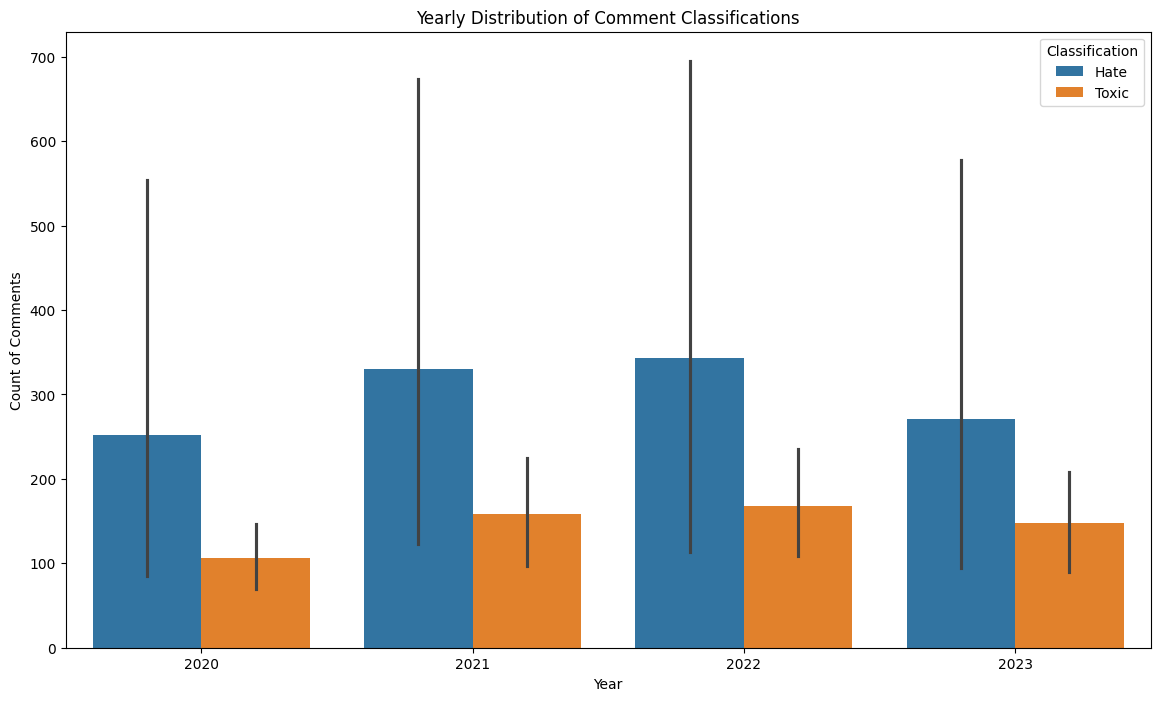

In [13]:
# Creating the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_hate_toxic, x="year", y="Classification Count", hue="General Classification"
)
plt.title("Yearly Distribution of Comment Classifications")
plt.xlabel("Year")
plt.ylabel("Count of Comments")
plt.legend(title="Classification")
plt.show()

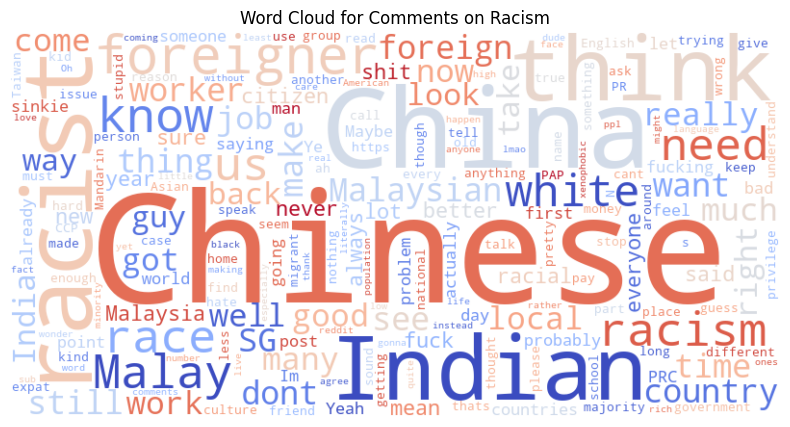

In [15]:
racism_comments = df_filtered[df_filtered["Final Topic Name"] == "Race"]["text"]
racism_text = " ".join(comment for comment in racism_comments)

# Create a set of stop words to remove
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(
    [
        "comment",
        "say",
        "singapore",
        "singaporean",
        "people",
        "singaporeans",
        "u",
        "even",
        "will",
        "one",
        "lol",
        "go",
    ]
)  # Add any specific words you want to exclude


# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    collocations=False,
    stopwords=custom_stopwords,
    colormap="coolwarm",
    random_state=475,
).generate(racism_text)

# Plot the Word Cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # No axis for neat visualization
plt.title("Word Cloud for Comments on Racism")
plt.show()